# 🏉 Go long! Long range transformers

In recent research there has been an extensive study for improving the calculation of attention in transformer architectures. Mostly for improving their capacity to handle longer sequences. 👊

The attention calculation is known to be quadratic in compatation time with respect to the sequence length 👎. These recent advances, however, are able to perform attention calculation in linear time with respect to the sequence length. This allows us to scale the transformer architecture such that it can handle input sequences beyond the usual 512 token length. 

In this notebook we compare traditional transfomers with novel efficient transformers. We'll use roBERTa as a baseline to compare against LongFormer and BigBird.  

Let's put these architectures to the test and see which one comes out on top 🏆!  


## 🛠️ Getting started: Install packages & download models

The below cells will setup everything that is required to get started with keyword extraction:

* Install python specific packages
* Import required packages

In [13]:
!pip install -q sklearn transformers datasets torch plotly colour

In [65]:
import time 
import sys 
import json
import pandas as pd
import numpy as np
from enum import Enum
import shelve
import torch

import plotly.express as px
import plotly.graph_objects as go


from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import  BigBirdTokenizerFast,BigBirdForSequenceClassification
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import LongformerConfig, LongformerForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import LongformerTokenizerFast
from transformers import TransfoXLTokenizer, TransfoXLForSequenceClassification
from datasets import load_dataset, Dataset, load_metric
from colour import Color

## 💾 Dataset & downstream task

We will use the IMDB movie review dataset for binary sentiment classification. In the paper publication of LongFormer and BigBird, both architectures were compared against RoBERTa with this exact dataset.
*   13.6 % of the reviews are larger than 512 wordpieces 
*   evaluation was done on the entire dataset and the performance improvement was .4% and .8% compared to the RoBERTa architecture for LongFormer and BigBird respectively 💪.

We aim to gain more insight in when to use which architecture, therefore we will go *one step beyond 🔥*, and evaluate the architectures on 2 distinct subsets of the data, namely: 

1.   Short sequences: containting less than 512 wordpieces but more than 256 wordpieces
2.   Long sequences: containing more than 512 wordpieces






In [ ]:
ds = load_dataset('imdb')

class IMDBDatasetTokenCountType(Enum):
    SHORT = 1
    LONG = 2

def filter_dataset_with_tokencount(ds, tokencount_type):
    tokenizer =  RobertaTokenizer.from_pretrained('roberta-base')
    if tokencount_type == IMDBDatasetTokenCountType.LONG:
        return ds.filter(lambda x: len(tokenizer.batch_encode_plus([x['text']]).input_ids[0]) > 512)
    if tokencount_type == IMDBDatasetTokenCountType.SHORT:
        return ds.filter(lambda x: len(tokenizer.batch_encode_plus([x['text']]).input_ids[0]) < 512).filter(lambda x: len(tokenizer.batch_encode_plus([x['text']]).input_ids[0]) > 256)
    
def filter_train_test_dataset_with_tokencount(train_ds, test_ds, tokencount_type):
    filt_train_ds =  filter_dataset_with_tokencount(train_ds, tokencount_type)
    filt_test_ds = filter_dataset_with_tokencount(test_ds, tokencount_type)
    return filt_train_ds, filt_test_ds

In [13]:
def get_deep_size(obj, seen=None):
    """Recursively accumulates size of objects"""
    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()
    obj_id = id(obj)
    if obj_id in seen:
        return 0
    # Important mark as seen *before* entering recursion to gracefully handle
    # self-referential objects
    seen.add(obj_id)
    if isinstance(obj, dict):
        size += sum([get_deep_size(v, seen) for v in obj.values()])
        size += sum([get_deep_size(k, seen) for k in obj.keys()])
    elif hasattr(obj, '__dict__'):
        size += get_deep_size(obj.__dict__, seen)
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum([get_deep_size(i, seen) for i in obj])
    return size


# Models

Run the cells below to redo the training of each model

🛎️ Disclaimer: this will take some time, you could also opt for downloading our final results by running the following import cell and skipping the training phases. 

## Importing results

In [ ]:
#wget models directory from public github

## Training

In [14]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

def train_and_evaluate(model, identifier, tokenizer, train_ds, test_ds, max_length=1024):
    def tokenization(batched_text):
        return tokenizer(batched_text['text'], padding='max_length', truncation=True, max_length=max_length)

    # tokenizing both the training and test dataset 
    train_ds = train_ds.map(
        tokenization, batched=True, batch_size=len(train_ds), remove_columns=['text'])
    test_ds = test_ds.map(tokenization, batched=True,
                          batch_size=len(test_ds),  remove_columns=['text'])
    train_ds.set_format(
        'torch', columns=['input_ids', 'attention_mask', 'label'])
    test_ds.set_format('torch', columns=[
                       'input_ids', 'attention_mask', 'label'])


    parameters = model.num_parameters()
    training_args = TrainingArguments(
        num_train_epochs=5,
        per_device_train_batch_size=4,
        gradient_accumulation_steps=2,
        per_device_eval_batch_size=4,
        evaluation_strategy="steps",
        eval_steps=100, 
        disable_tqdm=False,
        load_best_model_at_end=True,
        metric_for_best_model='accuracy', # default value is validation loss, we want the model with the highest accuracy 
        warmup_steps=200,
        logging_steps=100,
        learning_rate=5e-6,
        fp16=True,
        dataloader_num_workers=0,
        output_dir='./{}-classification-consumer-complaints-results'.format(
            identifier),
        run_name='{}-classification-consumer-complaints'.format(identifier),
        logging_dir='./{}-classification-consumer-complaints-logging'.format(
            identifier),
        save_strategy="steps"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        compute_metrics=compute_metrics,
        train_dataset=train_ds,
        eval_dataset=test_ds,
    )
    start_time = time.time()
    trainer.train()
    duration = time.time() - start_time

    metrics = trainer.evaluate()

    trainer.save_model(f"models/{identifier}")
    tokenizer.save_pretrained(f"models/{identifier}")

    return trainer, parameters, metrics, duration

In [15]:
token_count_cutoff = IMDBDatasetTokenCountType.LONG # Run for both SHORT and LONG scenario

In [ ]:
train_ds, test_ds = filter_train_test_dataset_with_tokencount(ds['train'], ds['test'], token_count_cutoff)
# To fairly compare both scenarios, we want to limit the size of both the training and test set to the most most restricting size. 
max_train_samples = 1270
max_test_samples = 1186

# shuffle datasets to avoid imbalanced data issues during training/evaluation
train_ds = train_ds.shuffle(seed=42).select(range(max_train_samples))
test_ds = test_ds.shuffle(seed=42).select(range(max_test_samples))


In [17]:
def run_training(model, tokenizer, model_name, train_ds, test_ds, max_length=1024):
    torch.cuda.empty_cache()

    identifier = '{}-{}'.format(model_name, token_count_cutoff.name).lower()
    trainer, parameters, metrics, duration  = train_and_evaluate(model, identifier, tokenizer, train_ds, test_ds, max_length)
    
    
    results_and_metrics = {
        "model_name": model_name,
        "parameters": parameters,
        "artefact_size": get_deep_size(trainer.model),
        "duration": duration,
        "metrics": metrics,
        'tokencount': token_count_cutoff.name
    }
    with open(f'./models/{identifier}/results.json', "w") as fd:
        json.dump(results_and_metrics, fd)
    del model 
    del trainer 


### roBERTa

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

model = RobertaForSequenceClassification.from_pretrained(
    'roberta-base',  gradient_checkpointing=True, num_labels=2)

run_training(model, tokenizer, 'roberta', train_ds, test_ds, max_length=512)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
100,0.694100,0.691903,0.489039,0.656852,0.489039,1.000000
200,0.663400,0.432657,0.850759,0.840684,0.879473,0.805172
300,0.360200,0.351535,0.891231,0.888118,0.893543,0.882759
400,0.286200,0.443211,0.887858,0.879855,0.924099,0.839655
500,0.258600,0.450579,0.895447,0.888087,0.931818,0.848276
600,0.255000,0.485321,0.899663,0.900251,0.876020,0.925862


### LongFormer

In [ ]:
tokenizer = LongformerTokenizerFast.from_pretrained('allenai/longformer-base-4096')
model = LongformerForSequenceClassification.from_pretrained('allenai/longformer-base-4096',
                                                            gradient_checkpointing=True,
                                                            attention_window=128,  num_labels=2)
run_training(model, tokenizer, 'longformer', train_ds, test_ds)

### BigBird

In [18]:
tokenizer = BigBirdTokenizerFast.from_pretrained('google/bigbird-roberta-base')
model = BigBirdForSequenceClassification.from_pretrained(
    'google/bigbird-roberta-base', gradient_checkpointing=True, num_labels=2)

run_training(model, tokenizer, 'big-bird', train_ds, test_ds)

Some weights of the model checkpoint at google/bigbird-roberta-base were not used when initializing BigBirdForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BigBirdForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BigBirdForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BigBirdForSequenceClassifica

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
100,0.693500,0.686911,0.501686,0.660540,0.495263,0.991379
200,0.645400,0.484782,0.844013,0.845705,0.819063,0.874138
300,0.324800,0.259358,0.908094,0.906758,0.899830,0.913793
400,0.202000,0.277644,0.910624,0.903986,0.952290,0.860345
500,0.164200,0.280647,0.923272,0.920105,0.937388,0.903448
600,0.126400,0.303254,0.922428,0.920962,0.917808,0.924138
700,0.125600,0.321688,0.922428,0.921233,0.914966,0.927586


# Visualize

In [3]:
import os 
run_dict = []

# loop to collect the results from each model
for root, dirs, files in os.walk('./models'):
    for name in files:
        if name.endswith(("results.json")):
            full_path = os.path.join(root, name)
            with open(full_path) as f:
                data = json.load(f)
                run_dict.append(data)


In [4]:
df = pd.DataFrame(run_dict)
df2 = df.metrics.apply(pd.Series)
result = pd.concat([df.drop('metrics', axis=1), df2], axis=1)
result['max_token_length'] = result['tokencount'].apply(lambda x: 512 if x == "SHORT" else 1024 )
result["iden"] = result["model_name"] + '-' + result["max_token_length"].astype(str)
result['parameters'] /= 1e6
result

,model_name,parameters,artefact_size,duration,tokencount,eval_loss,eval_accuracy,eval_f1,eval_precision,eval_recall,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,max_token_length,iden
0,longformer,148.660994,839482,2054.166195,SHORT,0.263781,0.941821,0.941476,0.918874,0.965217,68.7760,17.244,4.318,5.0,512,longformer-512
1,big-bird,128.060930,711616,2387.062487,SHORT,0.219696,0.943508,0.941891,0.939446,0.944348,74.1597,15.993,4.005,5.0,512,big-bird-512
2,roberta,124.647170,743692,795.234547,SHORT,0.217354,0.946880,0.946200,0.929530,0.963478,24.7230,47.972,12.013,5.0,512,roberta-512
3,longformer,148.660994,839482,2049.965436,LONG,0.371911,0.923272,0.921888,0.917949,0.925862,68.2604,17.375,4.351,5.0,1024,longformer-1024
4,big-bird,128.060930,711616,2360.915053,LONG,0.280647,0.923272,0.920105,0.937388,0.903448,75.4542,15.718,3.936,5.0,1024,big-bird-1024
5,roberta,124.647170,743692,794.416961,LONG,0.485321,0.899663,0.900251,0.876020,0.925862,24.7082,48.000,12.020,5.0,1024,roberta-1024


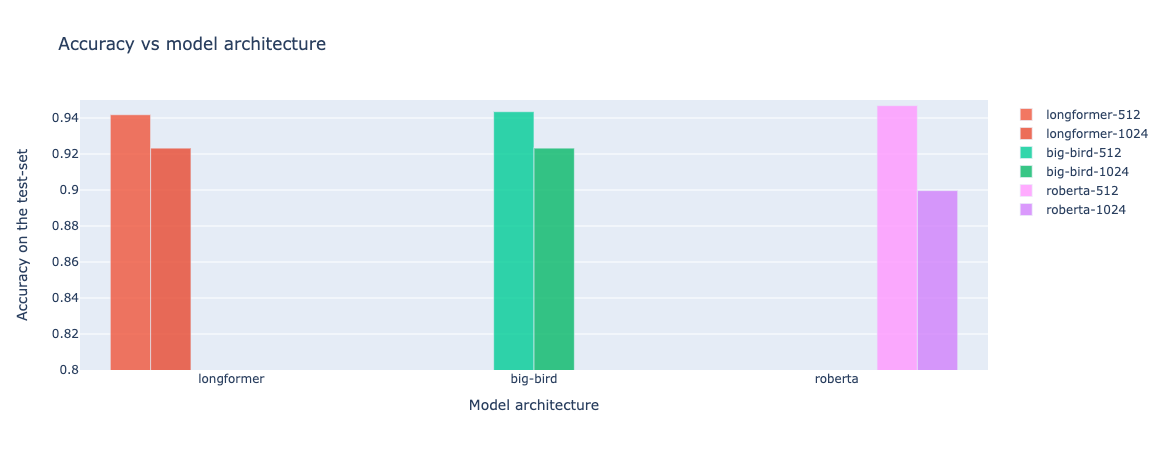

In [66]:
fig = go.Figure()
colors=[px.colors.qualitative.Plotly[1],px.colors.qualitative.Plotly[2],px.colors.qualitative.Plotly[8]]

for index, model_name in enumerate(result['model_name'].unique()):
    trace_data = result[result.model_name == model_name].sort_values('max_token_length').reset_index()
    color_map = list(Color(colors[index]).range_to(Color('#000'), 75))
    for i, row in trace_data.iterrows():
        fig.add_trace(go.Bar(
            x=[row["model_name"]],
            y=[row["eval_accuracy"]],
            marker_color=color_map[i*5].hex,
            opacity=0.8,
            name=row['iden'],
        ))

fig.update_layout(
    title="Accuracy vs model architecture",
    xaxis_title="Model architecture",
    yaxis_title="Accuracy on the test-set",
    yaxis_range=[0.8,0.95]
    
)

fig.show()

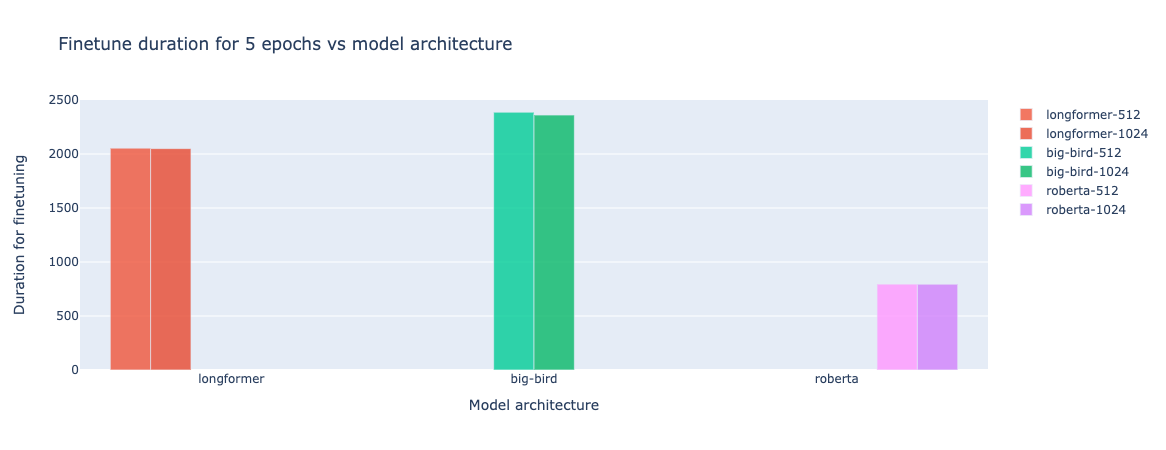

In [70]:
fig = go.Figure()
colors=[px.colors.qualitative.Plotly[1],px.colors.qualitative.Plotly[2],px.colors.qualitative.Plotly[8]]

for index, model_name in enumerate(result['model_name'].unique()):
    trace_data = result[result.model_name == model_name].sort_values('max_token_length').reset_index()
    color_map = list(Color(colors[index]).range_to(Color('#000'), 75))
    for i, row in trace_data.iterrows():
        fig.add_trace(go.Bar(
            x=[row["model_name"]],
            y=[row["duration"]],
            marker_color=color_map[i*5].hex,
            opacity=0.8,
            name=row['iden'],
        ))

fig.update_layout(
    title="Finetune duration for 5 epochs vs model architecture",
    xaxis_title="Model architecture",
    yaxis_title="Duration for finetuning",
    yaxis_range=[0,2500]
    
)

fig.show()

# 🎁 Wrapping up 

Nicely done! Let's wrap up some of our findings 🧪.

* Both LongFormer and BigBird outperform roBERTa for longer sequences by a small margin 💥 **Sparse attention for the win** 👑
* BigBird and LongFormer also show excellent performance on shorter sequences, in line with roBERTa's performance 💪 
* The **performance hit** between short and long sequence lengths is **less noticeable** for the efficient transformer architectures 
* LongFormer and BigBird have **higher training and inference times**. However, we didn't use the architectures to its full capactity of 4096 wordpieces 🙋‍

